In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
# Data Importing
prices = pd.read_excel('./rvi/Supra prices.xlsx')

In [3]:
# 옵션
n = 1000000
term = 36
value = 12.5
adj = value/(prices.iloc[0,4]*2/5+prices.iloc[0,5]*3/5) # 가격 보정
cover_rate = 0.85
cover = value*cover_rate
rate = 0.075
premium = value*rate


<h2> <b>목차</b> </h2>
<h3> Ⅰ. 연도별 선박가격 추이 </h3>
<h3> Ⅱ. 방법 1 : 선가 변화율 모형을 이용한 시뮬레이션 </h3>
<ol>
    <li> 선령 11년 선박가격 / 선령 10년 선박가격 비율 </li>
    <li> 선령 10년 선박의 월별 가격변화율 </li>
    <li> 손해액 시뮬레이션 </li>
</ol>

<h3> Ⅲ. 방법 2 : 선박 가격 모형을 이용한 시뮬레이션 </h3>
<ol> 
    <li> 선령 11년 선박가격 </li>
    <li> 손해액 시뮬레이션 </li>
</ol>
<h3> Ⅳ. 주성분 분석(PCA) </h3>
<h3> Ⅴ. 시계열 분석(ARIMA) </h3>
<h2>----------------------------------------------------------------------------------------------------------------------------</h2>

## Ⅰ. 연도별 선박가격 추이

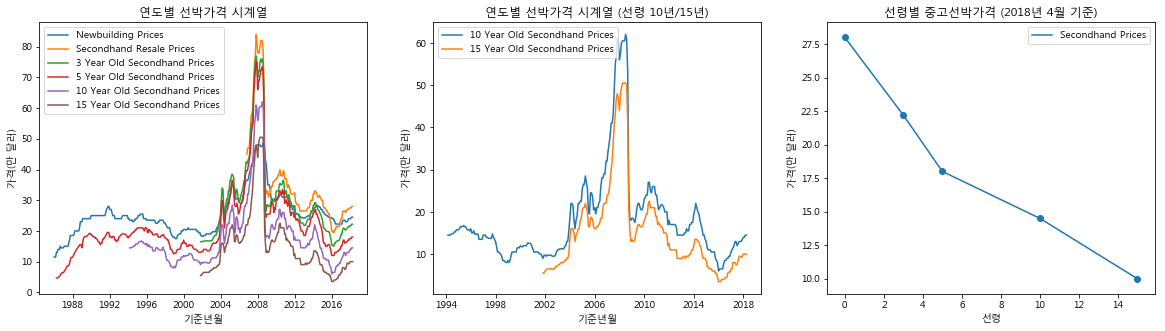

In [4]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
prices.columns = ['Date','NB','Resale','3y','5y','10y','15y']

ax[0].plot(prices['Date'], prices['NB'], label='Newbuilding Prices')
ax[0].plot(prices['Date'], prices['Resale'], label='Secondhand Resale Prices')
ax[0].plot(prices['Date'], prices['3y'], label='3 Year Old Secondhand Prices')
ax[0].plot(prices['Date'], prices['5y'], label='5 Year Old Secondhand Prices')
ax[0].plot(prices['Date'], prices['10y'], label='10 Year Old Secondhand Prices')
ax[0].plot(prices['Date'], prices['15y'], label='15 Year Old Secondhand Prices')
ax[0].set_xlabel('기준년월')
ax[0].set_ylabel('가격(만 달러)')
ax[0].set_title('연도별 선박가격 시계열')
ax[0].legend()

ax[1].plot(prices['Date'], prices['10y'], label='10 Year Old Secondhand Prices')
ax[1].plot(prices['Date'], prices['15y'], label='15 Year Old Secondhand Prices')
ax[1].set_xlabel('기준년월')
ax[1].set_ylabel('가격(만 달러)')
ax[1].set_title('연도별 선박가격 시계열 (선령 10년/15년)')
ax[1].legend()

ax[2].plot([0,3,5,10,15], prices.iloc[0,2:], label='Secondhand Prices')
ax[2].scatter([0,3,5,10,15], prices.iloc[0,2:], label='')
ax[2].set_xlabel('선령')
ax[2].set_ylabel('가격(만 달러)')
ax[2].set_title('선령별 중고선박가격 (2018년 4월 기준)')
ax[2].legend()

plt.show()

## Ⅱ. 방법 1 : 선가 변화율 모형을 이용한 시뮬레이션

### 1. 선령 11년 선박가격 / 선령 10년 선박가격 비율

    norm's Loglikehood = 467.91   AIC = -931.81   BIC = -908.18
    beta's Loglikehood = 482.02   AIC = -956.04   BIC = -908.78


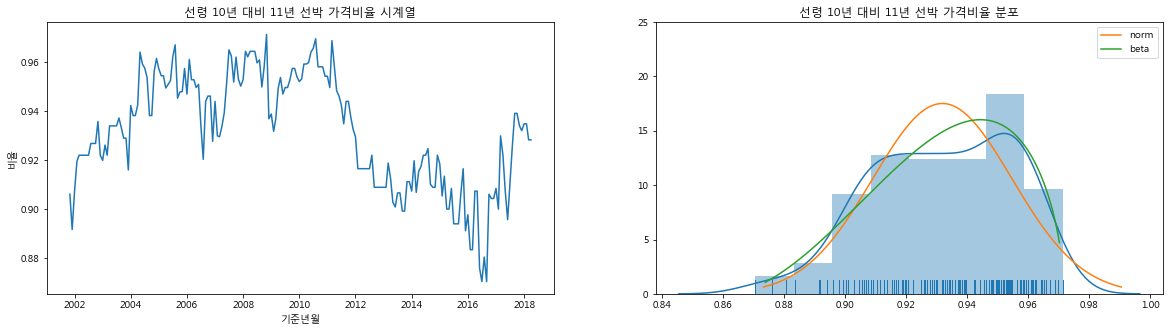

In [6]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

# 선령11년선가/선령10년선가 비율
depreciation = ((prices['15y']/prices['10y'])**(1/5)).dropna()
length = len(depreciation)
date = prices.iloc[:length,0]
depreciation.index = date

# 시계열
ax[0].plot(date, depreciation)
ax[0].set_title('선령 10년 대비 11년 선박 가격비율 시계열')
ax[0].set_xlabel('기준년월')
ax[0].set_ylabel('비율')


# 분포
result = []
sns.distplot(depreciation, norm_hist=True, rug=True, ax=ax[1])
dist_names = ['norm','beta']
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(depreciation)
    rv = dist(*param[:-2], loc=param[-2], scale=param[-1])
    mle = np.sum(np.log(rv.pdf(depreciation)))
    k = len(param)
    aic = -2*mle + 2*k
    bic = -2*mle + k*np.log(n)
    result.append([dist_name, mle, k, aic, bic])
    print('{:>8}\'s Loglikehood = {:.2f}   AIC = {:.2f}   BIC = {:.2f}'.format(dist_name, mle, aic, bic))
    x = np.linspace(rv.ppf(0.005), rv.ppf(0.995), 1000)
    pdf_fitted = rv.pdf(x)
    ax[1].plot(x, pdf_fitted, label=dist_name)

ax[1].set_ylim(0,25)
ax[1].set_title('선령 10년 대비 11년 선박 가격비율 분포')
ax[1].legend()

plt.show()

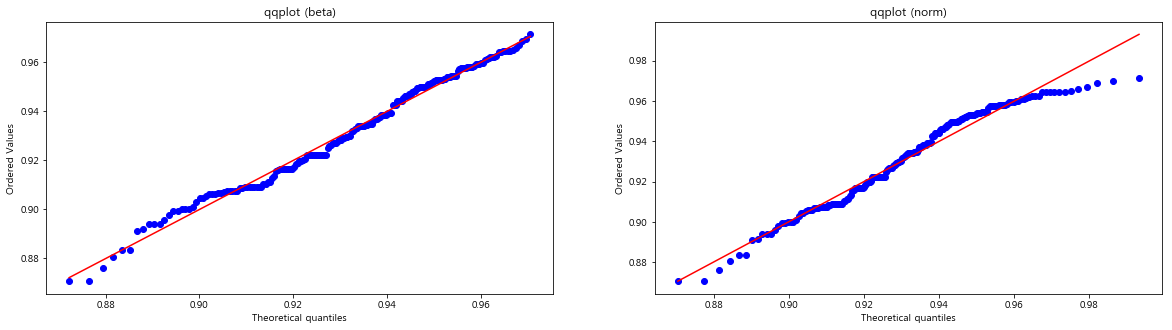

In [7]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

dist_names = ['beta', 'norm']
for i in range(len(dist_names)):
    dist = getattr(scipy.stats, dist_names[i])
    param = dist.fit(depreciation)
    res = scipy.stats.probplot(depreciation, dist=dist, sparams=(*param[:-2],param[-2],param[-1]), plot=ax[i])
    ax[i].set_title('qqplot ({:})'.format(dist_names[i]))

In [8]:
print('\n선택된 [선령 10년 대비 11년 선박가격 비율] 모형\n')

dist_name = 'beta'
dist = getattr(scipy.stats, dist_name)
param = dist.fit(depreciation)
print('  X ~ {:}(a={:.4f}, b={:.4f}, loc={:.4f}, scale={:.4f})'.format(dist_name,param[-4],param[-3],param[-2],param[-1]))
X = dist(*param[:-2], loc=param[-2], scale=param[-1])


선택된 [선령 10년 대비 11년 선박가격 비율] 모형

  X ~ beta(a=2.8837, b=1.6212, loc=0.8606, scale=0.1113)


### 2. 선령 10년 선박의 월별 가격변화율

  dgamma's Loglikehood = 3907.74   AIC = -7809.49   BIC = -7774.04
logistic's Loglikehood = 409.86   AIC = -815.72   BIC = -792.09


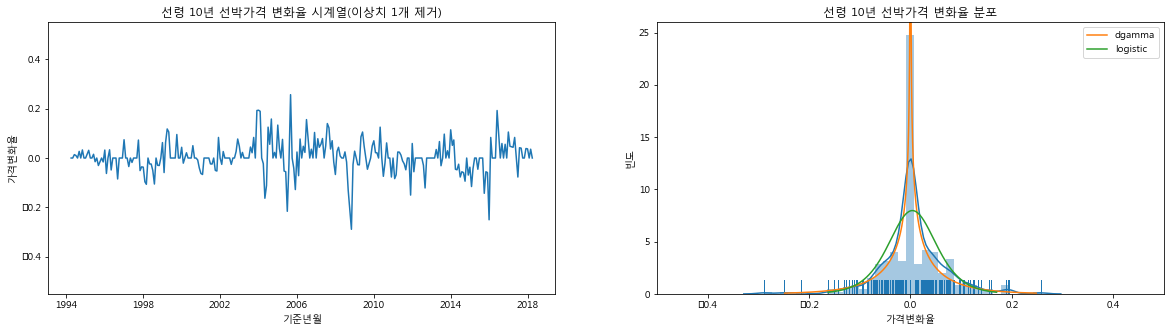

In [9]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
prices_10y = prices.set_index('Date')['10y']
prices_10y_inc = (prices_10y/prices_10y.shift(-1)-1).dropna()
prices_10y_inc = prices_10y_inc[prices_10y_inc>-0.5]   # Outlier (1개 제거)

# 시계열
ax[0].plot(prices_10y_inc)
ax[0].set_xlabel('기준년월')
ax[0].set_ylabel('가격변화율')
ax[0].set_ylim(-0.55,0.55)
ax[0].set_title('선령 10년 선박가격 변화율 시계열(이상치 1개 제거)')

# 분포
sns.distplot(prices_10y_inc, ax=ax[1], rug=True)
result = []
dist_names = ['dgamma','logistic']


for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(prices_10y_inc)
    rv = dist(*param[:-2], loc=param[-2], scale=param[-1])
    mle = np.sum(np.log(rv.pdf(prices_10y_inc)))
    k = len(param)
    aic = -2*mle + 2*k
    bic = -2*mle + k*np.log(n)
    result.append([dist_name, mle, k, aic, bic])
    print('{:>8}\'s Loglikehood = {:.2f}   AIC = {:.2f}   BIC = {:.2f}'.format(dist_name, mle, aic, bic))
    x = np.linspace(rv.ppf(0.005), rv.ppf(0.995), 1000)
    pdf_fitted = rv.pdf(x)
    ax[1].plot(x, pdf_fitted, label=dist_name)
result = pd.DataFrame(result, columns=['name','mle','k','aic','bic'])
ax[1].set_xlabel('가격변화율')
ax[1].set_ylabel('빈도')
ax[1].set_title('선령 10년 선박가격 변화율 분포')
ax[1].set_xlim(-0.5,0.5)
ax[1].legend()

plt.show()

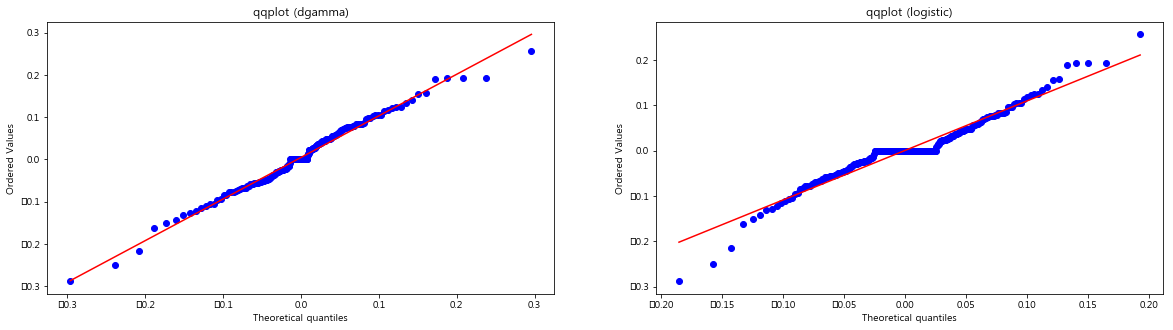

In [10]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

dist_names = ['dgamma','logistic']
for i in range(len(dist_names)):
    dist = getattr(scipy.stats, dist_names[i])
    param = dist.fit(prices_10y_inc)
    res = scipy.stats.probplot(prices_10y_inc, dist=dist, sparams=(*param[:-2],param[-2],param[-1]), plot=ax[i])
    ax[i].set_title('qqplot ({:})'.format(dist_names[i]))

In [11]:
dist_name = 'dgamma'
dist = getattr(scipy.stats, dist_name)
param = dist.fit(prices_10y_inc)

In [12]:
dist_names = ['dgamma','logistic']
print('\n선택된 [선령 10년 선박의 월별 가격변화율] 모형\n')

dist_name = 'dgamma'
dist = getattr(scipy.stats, dist_name)
param = dist.fit(prices_10y_inc)
print('  Y ~ {:}(a={:.4f}, loc={:.4f}, scale={:.4f})'.format(dist_name,param[-3],param[-2],param[-1]))

dist_name = 'logistic'
dist = getattr(scipy.stats, dist_name)
param = dist.fit(prices_10y_inc)
print('  Y ~ {:}(loc={:.4f}, scale={:.4f})'.format(dist_name,param[-2],param[-1]))


선택된 [선령 10년 선박의 월별 가격변화율] 모형

  Y ~ dgamma(a=0.5459, loc=0.0000, scale=0.0718)
  Y ~ logistic(loc=0.0038, scale=0.0314)


### 3. 손해액 시뮬레이션

보험료 : 0.94만 달러

분포 : dgamma
사고확률 : 57.14%
사고당 평균손해액 : 2.92만 달러
기대손실액 : 1.67만 달러
Value-at-Risk(99.5%) : 7.53만 달러

분포 : logistic
사고확률 : 40.68%
사고당 평균손해액 : 2.19만 달러
기대손실액 : 0.89만 달러
Value-at-Risk(99.5%) : 5.97만 달러


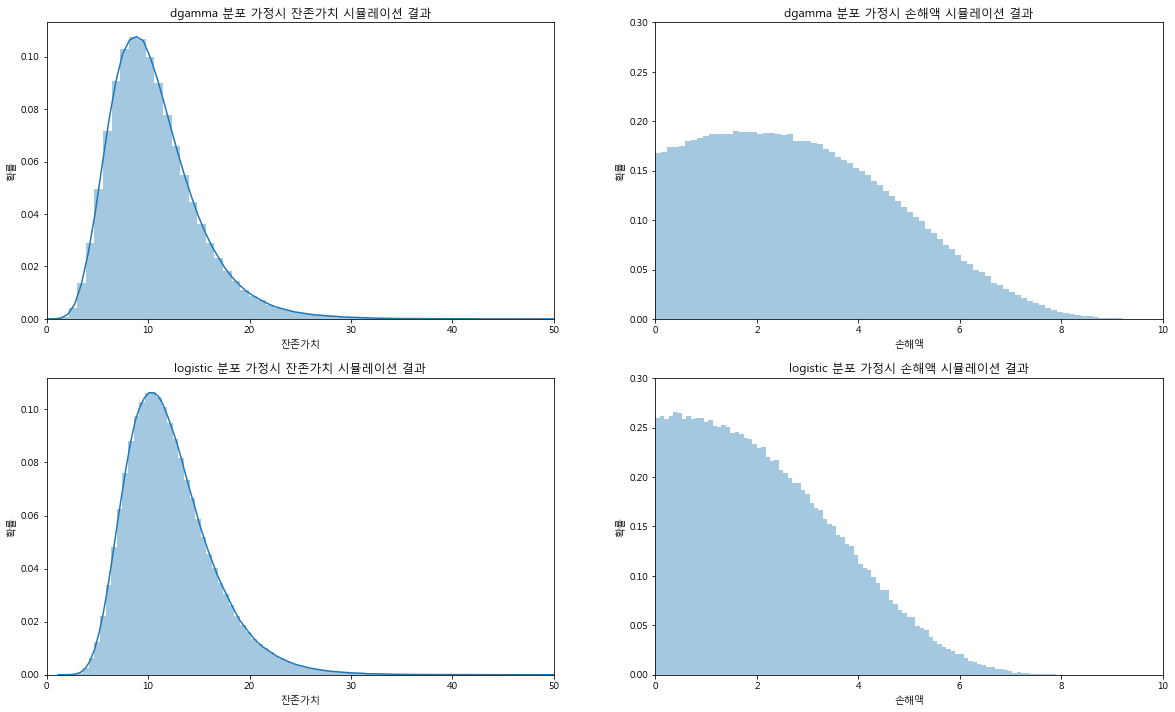

In [13]:
fig, axes = plt.subplots(2,2,figsize=(20,12))
print('보험료 : {:.2f}만 달러'.format(premium))

i=0
dist_names = ['dgamma','logistic']
result = []
for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(prices_10y_inc)
    Y = dist(*param[:-2], loc=param[-2], scale=param[-1])
    resids = adj*prices.iloc[0,5]*np.prod(1+Y.rvs(size=(term,n)), axis=0)*X.rvs(n)
    simulation = np.fmax(cover - resids,0)
    f = np.count_nonzero(simulation)
    freq = f/n
    claims = simulation[simulation>0]
    sev = np.sum(claims)/f
    var = np.percentile(simulation,99.5)
    result.append([dist_name,freq,sev,freq*sev,var])
    
    sns.distplot(resids, bins=100, norm_hist=True, ax=axes[i][0])
    axes[i][0].set_xlabel('잔존가치')
    axes[i][0].set_ylabel('확률')
    axes[i][0].set_xlim(0,50)
    axes[i][0].set_title('{} 분포 가정시 잔존가치 시뮬레이션 결과'.format(dist_name))

    sns.distplot(claims, bins=100, kde=False, norm_hist=True, ax=axes[i][1])
    axes[i][1].set_xlabel('손해액')
    axes[i][1].set_ylabel('확률')
    axes[i][1].set_xlim(0,10)
    axes[i][1].set_ylim(0,0.3)
    axes[i][1].set_title('{} 분포 가정시 손해액 시뮬레이션 결과'.format(dist_name))
    
    i+=1
result = pd.DataFrame(result, columns=['name','frequency','severity','loss','VaR(99.5%)'])

for i in result.index:
    print('\n분포 : {:5}\n사고확률 : {:.2%}\n사고당 평균손해액 : {:.2f}만 달러\n기대손실액 : {:.2f}만 달러\nValue-at-Risk(99.5%) : {:.2f}만 달러'.format(result.loc[i,'name'], result.loc[i,'frequency'], result.loc[i,'severity'], result.loc[i,'loss'], result.loc[i,'VaR(99.5%)']))
plt.show()

## Ⅲ. 방법 2 : 선박 가격 모형을 이용한 시뮬레이션 

### 1. 선령 11년 선박가격

gamma's Loglikehood = -787.64   AIC = 1581.28   BIC = 1616.73
 beta's Loglikehood = -788.83   AIC = 1585.67   BIC = 1632.93


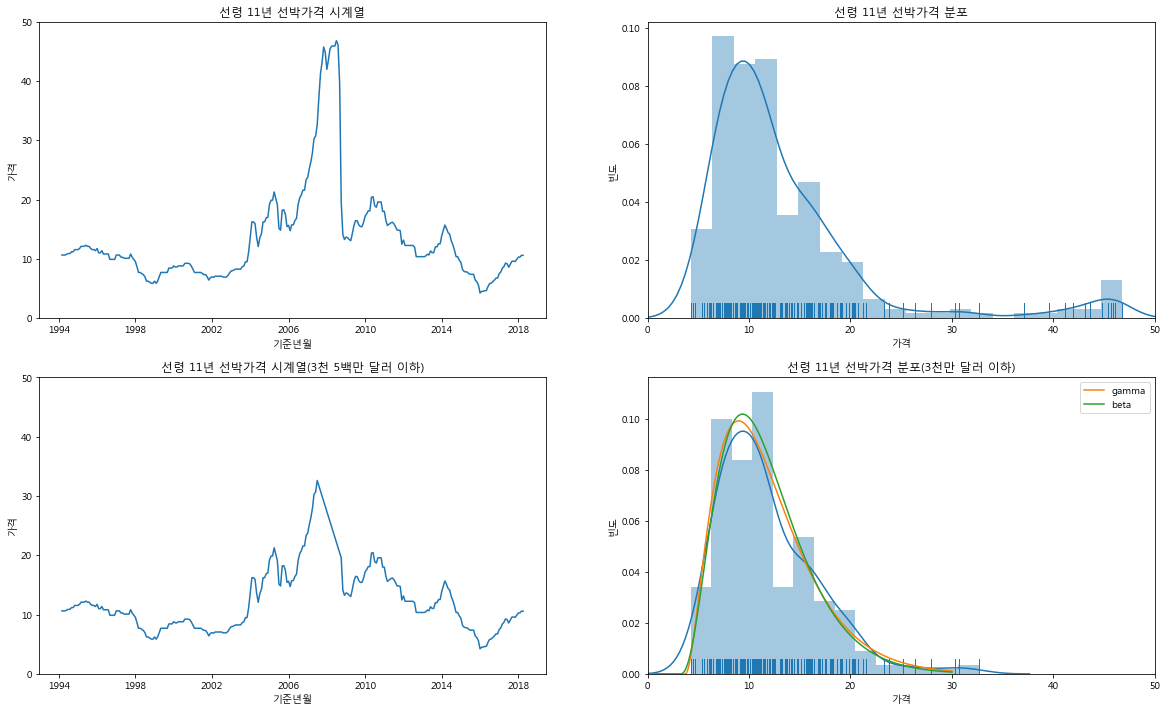

In [14]:
fig, ax = plt.subplots(2,2, figsize=(20,12))

depreciation = prices['15y']/prices['10y']
length = len(prices['10y'].dropna())
date = prices.iloc[:n,0]
depreciation_filled = depreciation.fillna(depreciation.dropna().mean())[:n]
prices['11y'] = prices['10y'].dropna()*depreciation_filled**(1/5)
adj = value/(prices.iloc[0,4]*2/5+prices.iloc[0,5]*3/5) # 가격 보정

prices_11y = prices[['Date','11y']].dropna().set_index('Date')['11y'].dropna()*adj
prices_11y_trunc = prices_11y[prices_11y < 35].dropna()


ax[0][0].plot(prices_11y)
ax[0][0].set_xlabel('기준년월')
ax[0][0].set_ylabel('가격')
ax[0][0].set_ylim(0,50)
ax[0][0].set_title('선령 11년 선박가격 시계열')

sns.distplot(prices_11y, ax=ax[0][1], rug=True)
ax[0][1].set_xlabel('가격')
ax[0][1].set_ylabel('빈도')
ax[0][1].set_xlim(0,50)
ax[0][1].set_title('선령 11년 선박가격 분포')

ax[1][0].plot(prices_11y_trunc)
ax[1][0].set_xlabel('기준년월')
ax[1][0].set_ylabel('가격')
ax[1][0].set_ylim(0,50)
ax[1][0].set_title('선령 11년 선박가격 시계열(3천 5백만 달러 이하)')

#dist_names = [ 'alpha', 'anglit', 'arcsine', 'beta', 'betaprime', 'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang', 'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min', 'weibull_max', 'wrapcauchy']
dist_names = ['gamma','beta']
x = np.linspace(0,30,1000)
result = []

sns.distplot(prices_11y_trunc, ax=ax[1][1], rug=True)

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(prices_11y_trunc)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    mle = np.sum(np.log(dist.pdf(prices_11y_trunc, *param[:-2], loc=param[-2], scale=param[-1])))
    k = len(param)
    aic = -2*mle + 2*k
    bic = -2*mle + k*np.log(n)
    result.append([dist_name, mle, k, aic, bic])
    print('{:>5}\'s Loglikehood = {:.2f}   AIC = {:.2f}   BIC = {:.2f}'.format(dist_name, mle, aic, bic))
    plt.plot(x, pdf_fitted, label=dist_name)
result = pd.DataFrame(result, columns=['name','mle','k','aic','bic'])
ax[1][1].set_xlabel('가격')
ax[1][1].set_ylabel('빈도')
ax[1][1].set_xlim(0,50)
ax[1][1].set_title('선령 11년 선박가격 분포(3천만 달러 이하)')
ax[1][1].legend(loc='best')


plt.show()

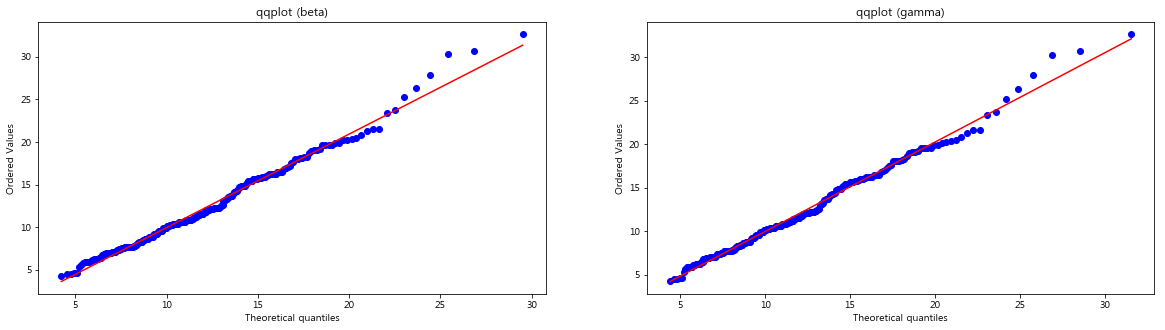

In [15]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

dist_names = ['beta','gamma']
for i in range(len(dist_names)):
    dist = getattr(scipy.stats, dist_names[i])
    param = dist.fit(prices_11y_trunc)
    res = scipy.stats.probplot(prices_11y_trunc, dist=dist, sparams=(*param[:-2],param[-2],param[-1]), plot=ax[i])
    ax[i].set_title('qqplot ({:})'.format(dist_names[i]))

In [16]:
print('\n선택된 [선령 11년 선박가격] 모형\n')

dist_name = 'gamma'
dist = getattr(scipy.stats, dist_name)
param = dist.fit(prices_11y_trunc)
print('  Z ~ {:}(alpha={:.4f}, loc={:.4f}, scale={:.4f})'.format(dist_name,param[-3],param[-2],param[-1]))

dist_name = 'beta'
dist = getattr(scipy.stats, dist_name)
param = dist.fit(prices_11y_trunc)
print('  Z ~ {:}(a={:.4f}, b={:.4f}, loc={:.4f}, scale={:.4f})'.format(dist_name,param[-4],param[-3],param[-2],param[-1]))


선택된 [선령 11년 선박가격] 모형

  Z ~ gamma(alpha=2.8483, loc=3.7470, scale=2.8267)
  Z ~ beta(a=3.6277, b=92121947843.9063, loc=3.2093, scale=215548284339.4642)


### 2. 손해액 시뮬레이션

보험료 : 0.94만 달러

분포 : gamma
사고확률 : 47.68%
사고당 평균손해액 : 2.57만 달러
기대손실액 : 1.23만 달러
Value-at-Risk(99.5%) : 6.04만 달러

분포 : beta 
사고확률 : 47.05%
사고당 평균손해액 : 2.50만 달러
기대손실액 : 1.18만 달러
Value-at-Risk(99.5%) : 6.16만 달러


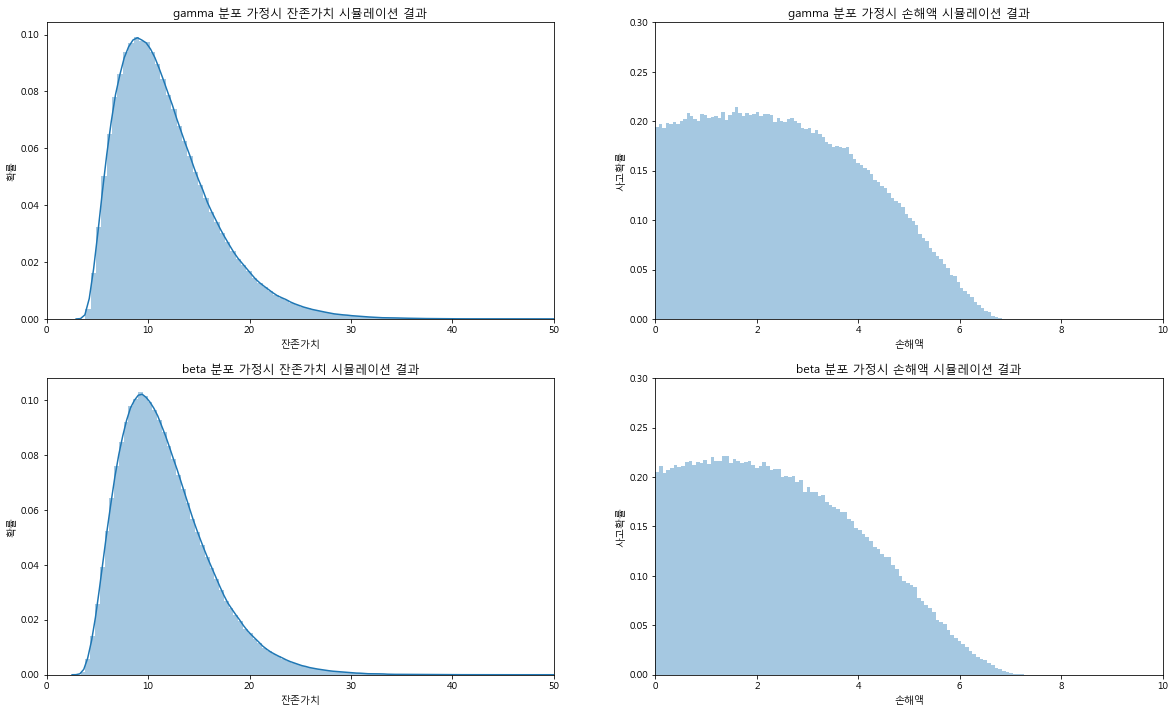

In [17]:
fig, ax = plt.subplots(2,2, figsize=(20,12))

print('보험료 : {:.2f}만 달러'.format(premium))

i=0
dist_names = ['gamma','beta']
result = []

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(prices_11y_trunc)
    resids = dist.rvs(size=n, *param[:-2], loc=param[-2], scale=param[-1])
    simulation = np.fmax(cover - resids,0)
    f = np.count_nonzero(simulation)
    freq = f/n
    claims = simulation[simulation>0]
    sev = np.sum(claims)/f
    var = np.percentile(simulation,99.5)
    result.append([dist_name,freq,sev,freq*sev,var])
    
    sns.distplot(resids, bins=100, kde=True, norm_hist=True, ax=ax[i][0])
    ax[i][0].set_xlabel('잔존가치')
    ax[i][0].set_ylabel('확률')
    ax[i][0].set_xlim(0,50)
    ax[i][0].set_title('{} 분포 가정시 잔존가치 시뮬레이션 결과'.format(dist_name))
    
    sns.distplot(claims, bins=100, kde=False, norm_hist=True, ax=ax[i][1])
    ax[i][1].set_xlabel('손해액')
    ax[i][1].set_ylabel('사고확률')
    ax[i][1].set_xlim(0,10)
    ax[i][1].set_ylim(0,0.3)
    ax[i][1].set_title('{} 분포 가정시 손해액 시뮬레이션 결과'.format(dist_name))
    i+=1
result = pd.DataFrame(result, columns=['name','frequency','severity','loss','VaR(99.5%)'])

for i in result.index:
    print('\n분포 : {:5}\n사고확률 : {:.2%}\n사고당 평균손해액 : {:.2f}만 달러\n기대손실액 : {:.2f}만 달러\nValue-at-Risk(99.5%) : {:.2f}만 달러'.format(result.loc[i,'name'], result.loc[i,'frequency'], result.loc[i,'severity'], result.loc[i,'loss'], result.loc[i,'VaR(99.5%)']))
plt.show()

## Ⅳ. 주성분 분석(PCA)

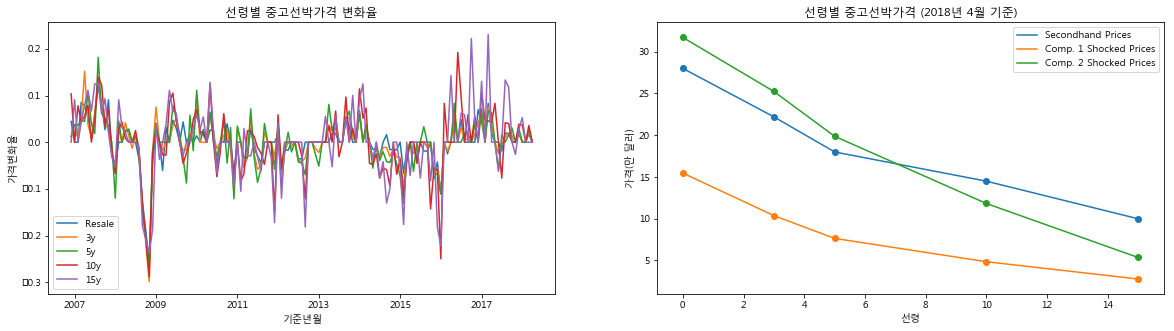

In [18]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

prices_pca = prices.set_index('Date').iloc[:,1:6].dropna()
prices_pca_inc = (prices_pca/prices_pca.shift(-1)-1).dropna()
prices_pca_inc = prices_pca_inc[prices_pca_inc>-0.5].dropna()

scaler = StandardScaler().fit(prices_pca_inc)
x = scaler.transform(prices_pca_inc)
pca = PCA().fit(x)
pca_fitted = pca.transform(x)
var1 = pca_fitted.std(axis=0)[0]*1.96*np.sqrt(36)
var2 = pca_fitted.std(axis=0)[1]*1.96*np.sqrt(36)
shock1 = scaler.inverse_transform(pca.inverse_transform(var1)[0])
shock2 = -scaler.inverse_transform(pca.inverse_transform(var2)[1])
current_prices  = np.array(prices.iloc[0,2:7])

ax[0].plot(prices_pca_inc)
ax[0].legend(prices_pca_inc.columns)
ax[0].set_xlabel('기준년월')
ax[0].set_ylabel('가격변화율')
ax[0].set_title('선령별 중고선박가격 변화율')

ax[1].plot([0,3,5,10,15], prices.iloc[0,2:7], label='Secondhand Prices')
ax[1].scatter([0,3,5,10,15], prices.iloc[0,2:7], label='')
ax[1].set_xlabel('선령')
ax[1].set_ylabel('가격(만 달러)')
ax[1].set_title('선령별 중고선박가격 (2018년 4월 기준)')
ax[1].plot([0,3,5,10,15], current_prices*(1+shock1), label='Comp. 1 Shocked Prices')
ax[1].scatter([0,3,5,10,15], current_prices*(1+shock1), label='')
ax[1].plot([0,3,5,10,15], current_prices*(1+shock2), label='Comp. 2 Shocked Prices')
ax[1].scatter([0,3,5,10,15], current_prices*(1+shock2), label='')
ax[1].legend()

plt.show()

## Ⅴ. 시계열 분석(ARIMA)

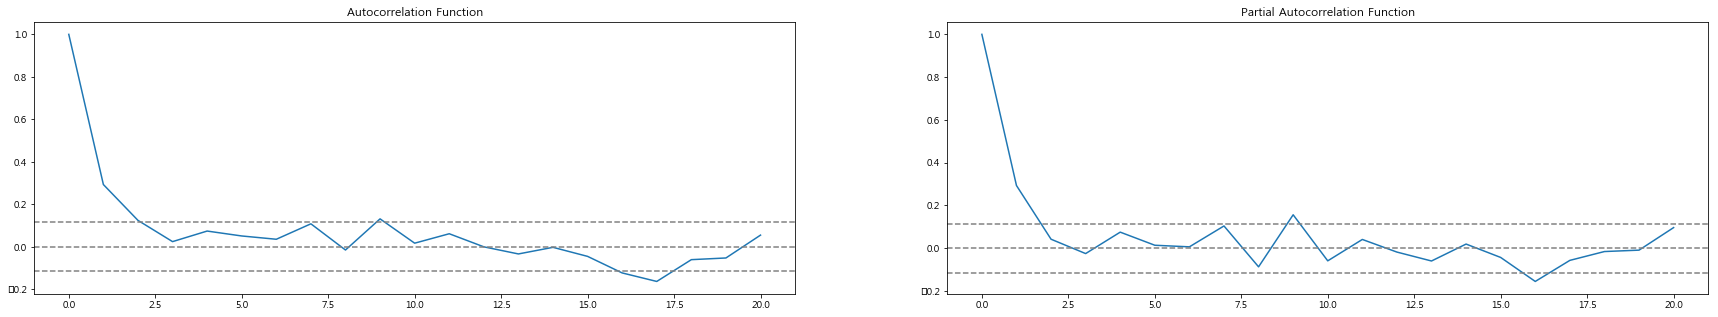

In [19]:
from statsmodels.tsa.stattools import acf, pacf
fig, axes = plt.subplots(1,2, figsize=(30,5))
lag_acf = acf(prices_10y_inc, nlags=20)
lag_pacf = pacf(prices_10y_inc, nlags=20, method='ols')

    
ax = axes[0]
ax.plot(lag_acf)
ax.axhline(y=0,linestyle='--',color='gray')
ax.axhline(y=-1.96/np.sqrt(len(prices_10y_inc)),linestyle='--',color='gray')
ax.axhline(y=1.96/np.sqrt(len(prices_10y_inc)),linestyle='--',color='gray')
ax.set_title('Autocorrelation Function')

ax = axes[1]
ax.plot(lag_pacf)
ax.axhline(y=0,linestyle='--',color='gray')
ax.axhline(y=-1.96/np.sqrt(len(prices_10y_inc)),linestyle='--',color='gray')
ax.axhline(y=1.96/np.sqrt(len(prices_10y_inc)),linestyle='--',color='gray')
ax.set_title('Partial Autocorrelation Function')
plt.show()

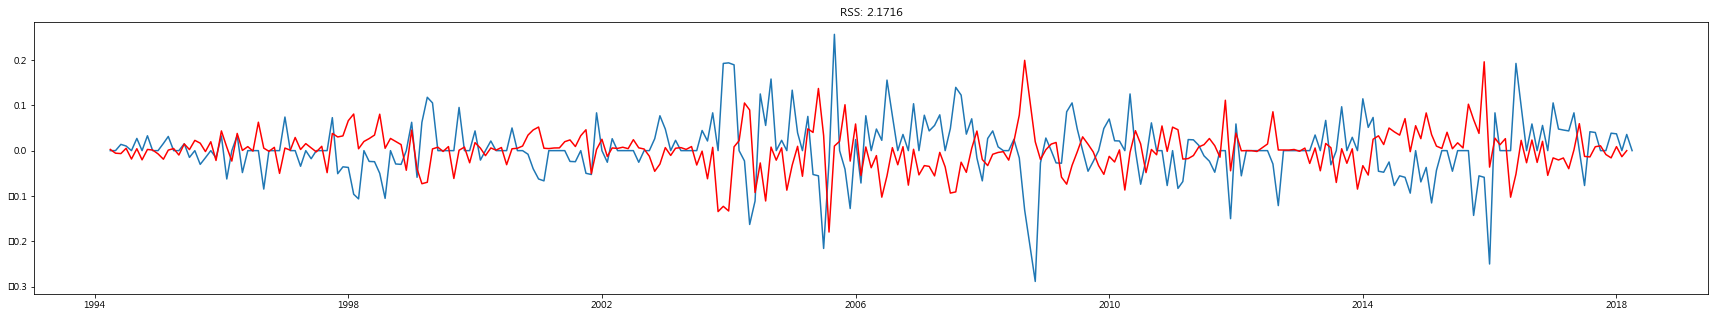

In [21]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(30,5))
p = 2
q = 3

model = ARIMA(prices_10y_inc, order=(p, 1, q))  
results_ARIMA = model.fit()  
plt.plot(prices_10y_inc)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: {:.4f}'.format(np.sum((results_ARIMA.fittedvalues-prices_10y_inc)**2)))
plt.show()

In [23]:
import codecs
from bs4 import BeautifulSoup

# 파일 불러오기
f = codecs.open('C:/Users/noilkwon/Downloads/180519_Bulkcarrier_TSA_ver1.0.html','r', 'utf-8')
soup = BeautifulSoup(f.read(),'html.parser')
f.close()

# 모든 input 삭제
for div in soup.findAll('div', {"class","input"}):
    div.decompose()
    
# 파일로 저장
html = soup.prettify('utf-8')
with open('output.html', 'wb') as file:
    file.write(html)